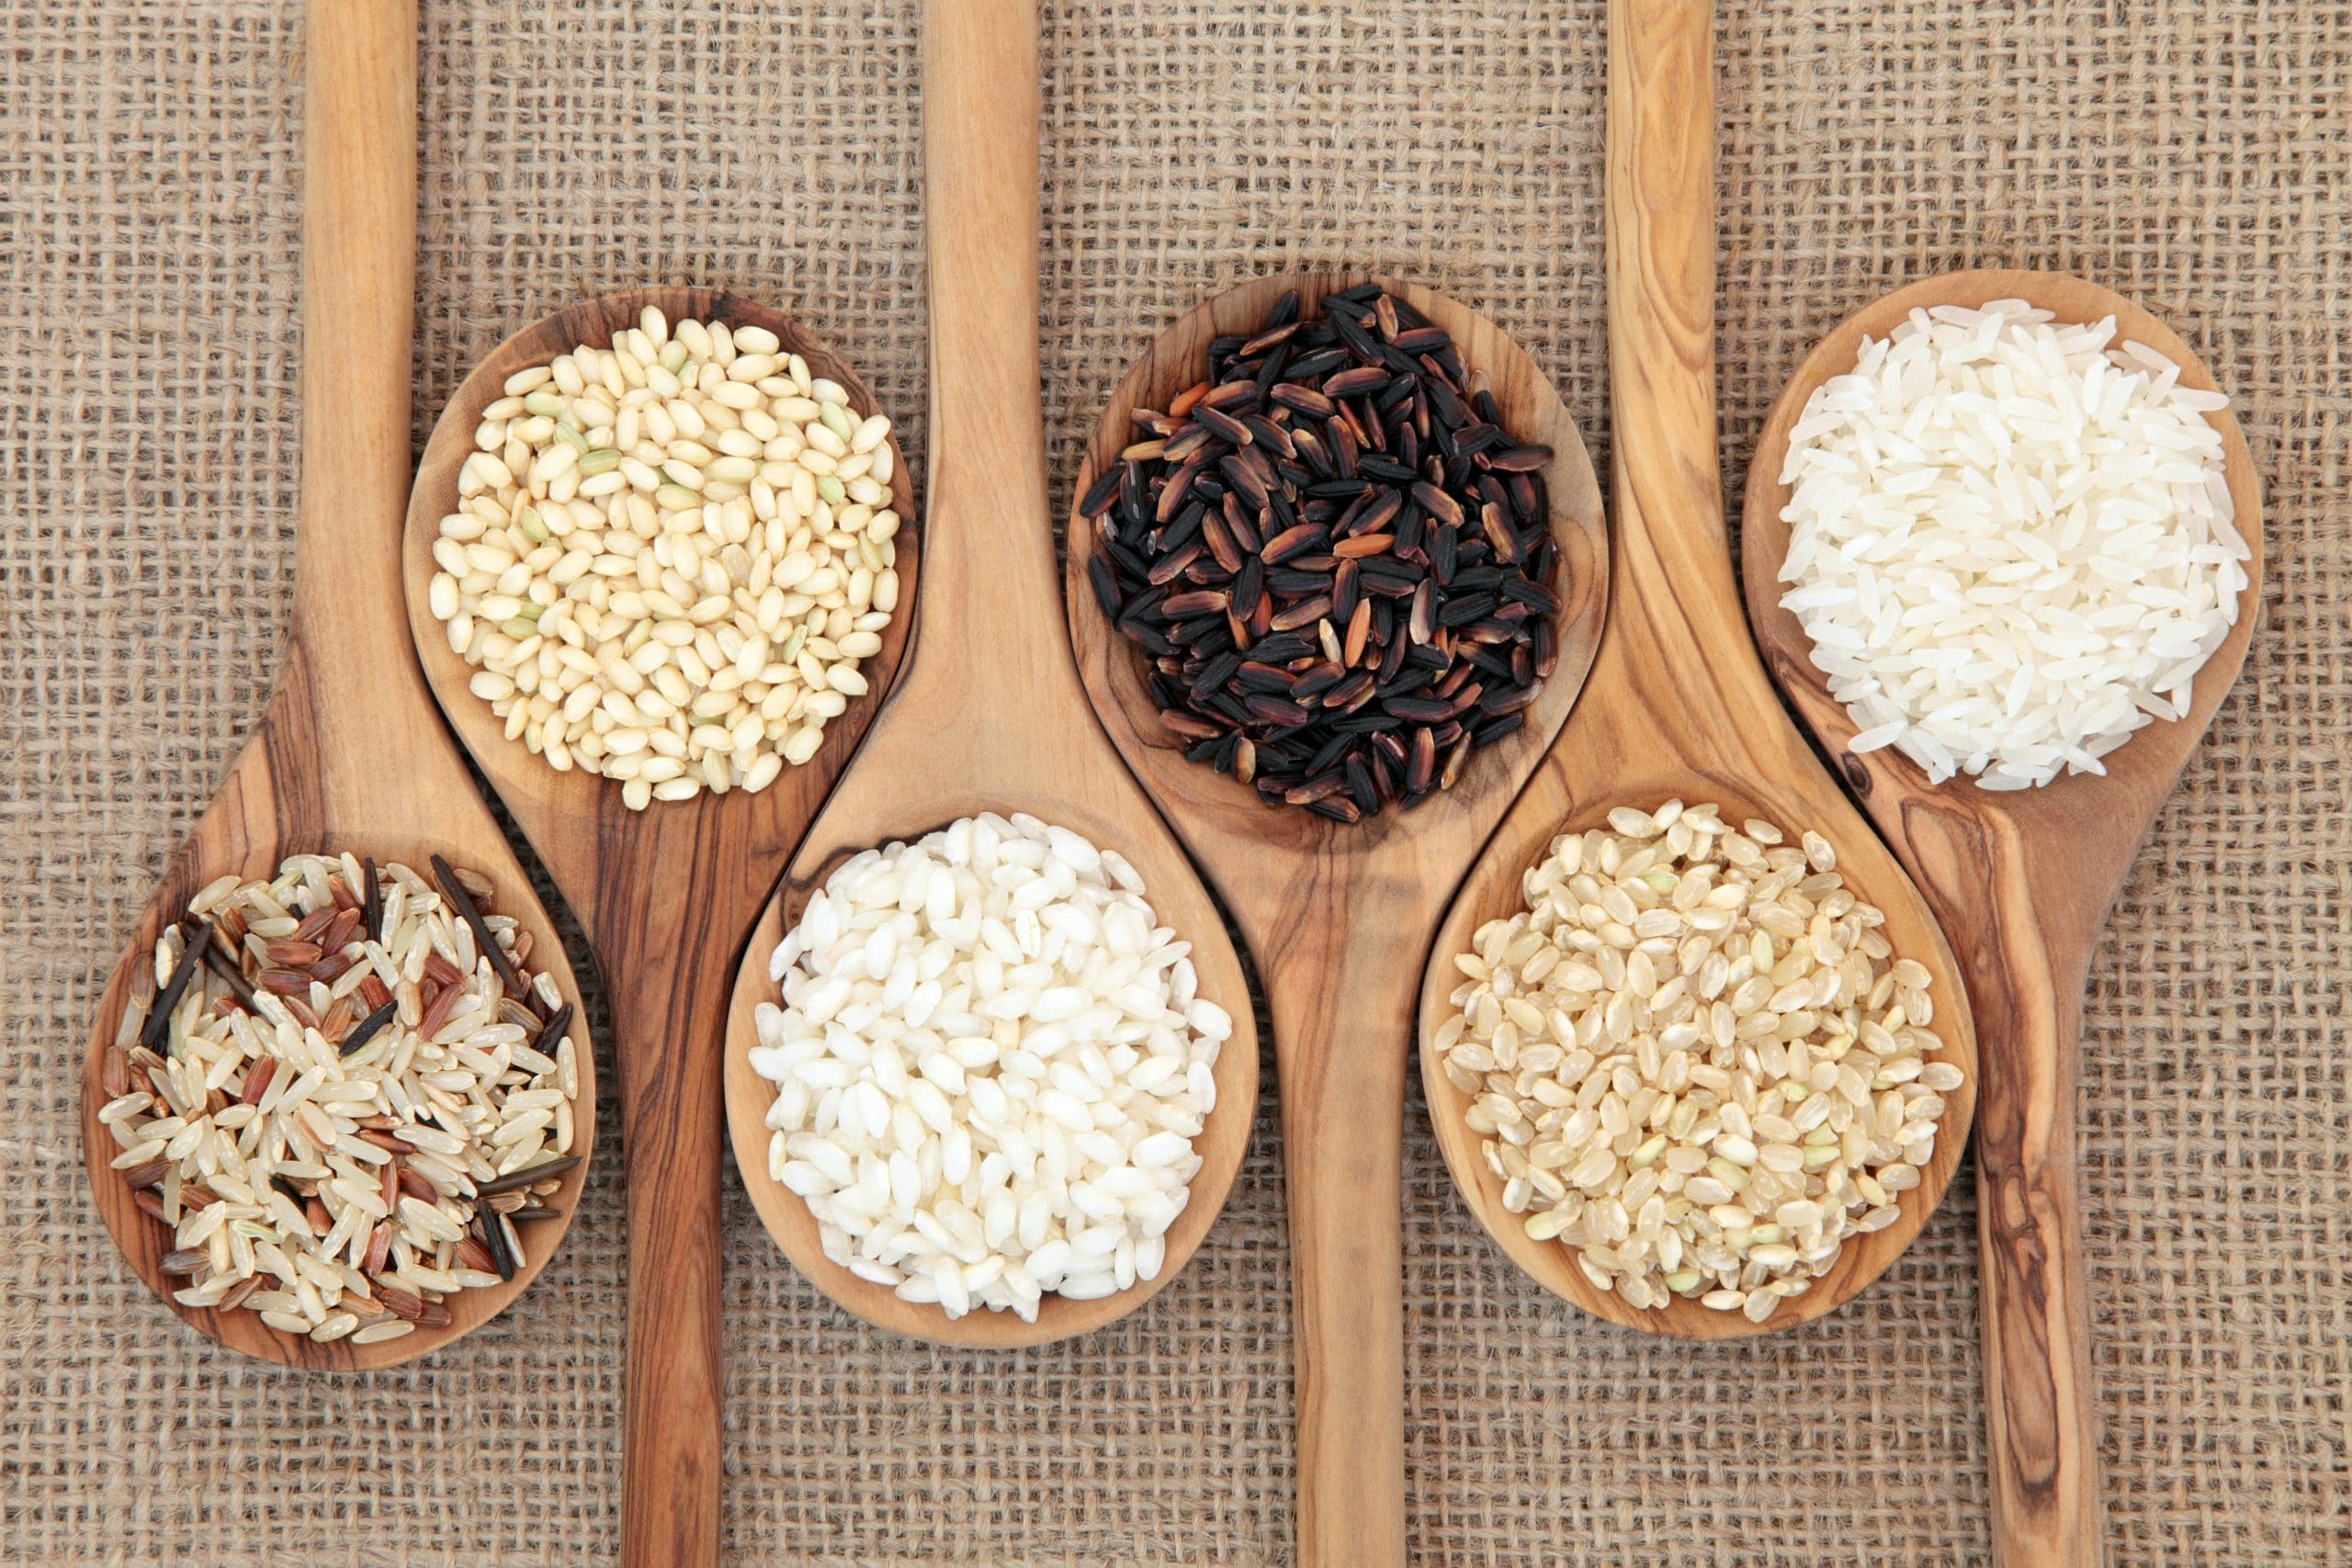

In [17]:
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from PIL import Image
import cv2
import glob
import os
import random
import subprocess

from skimage.io import imread
import matplotlib.gridspec as gridspec


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


import warnings
warnings.filterwarnings("ignore")

In [18]:
path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
Categories = [class_name for class_name in os.listdir(path) if class_name]
Categories.remove('Rice_Citation_Request.txt')
print(Categories)

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


In [19]:
#Creating a list like this: dataset = ['img_path': [], 'labels': []]
dataset = []
for class_name in Categories:
            Categories_path = os.path.join(path, class_name)  #get the classes of label
            #print(Categories_path)
            images = os.listdir(Categories_path) #Find the images files' name of all class
            #print(images,type(images))
            for img in images:
                img_path = os.path.join(Categories_path, img) #get the images of eah class
                #print(img_path)
                dataset.append((img_path, class_name))  # Dataset list creation
                #print(dataset)
    
            
df = pd.DataFrame(dataset, columns=['img_path', 'labels'])
df.head()



,img_path,labels
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


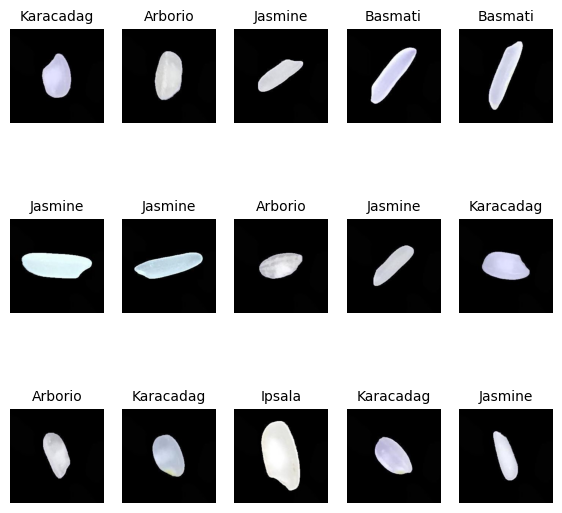

In [20]:
def rand_imshow(df):
    fig, axes = plt.subplots(3, 5, figsize=(7,7))
    random_images = random.sample(range(len(dataset)), 15)
    gs = gridspec.GridSpec(1, 5, wspace = 1.0, hspace = 1.0)
    for i, idx in enumerate(random_images):
        #print("i:", i, "and idx:", idx)
        row = i // 5
        col = i % 5
        img_path = df['img_path'].iloc[idx]
        labels = df['labels'].iloc[idx]
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(labels, fontsize = 10)
    plt.show()

            
rand_imshow(df)

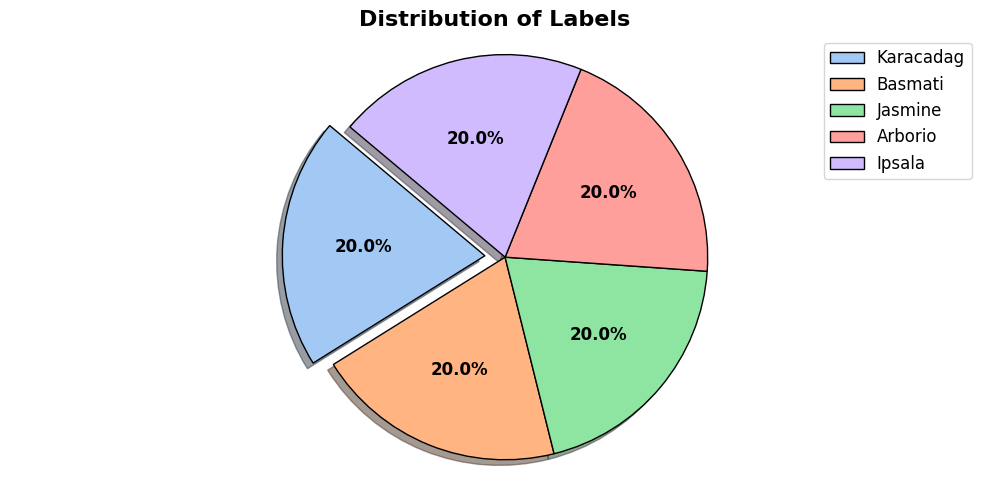

In [21]:
def label_counter(dataframe):
    ig, ax = plt.subplots(figsize = (10, 5))
    labels = df['labels'].value_counts().index
    sizes = df['labels'].value_counts().values
    colors = sns.color_palette('pastel')

    wedges, texts, autotexts = ax.pie(sizes, colors = colors, 
                                      autopct = '%1.1f%%', startangle = 140, 
                                      explode = (0.1, 0, 0, 0, 0), wedgeprops = dict(edgecolor = 'black'), shadow=True)

    ax.set_title('Distribution of Labels', fontsize = 16, fontweight = 'bold')
    ax.axis('equal') 
    ax.legend(wedges, labels, loc = "best", fontsize = 12)

    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')

    plt.tight_layout()
    plt.show()
    
label_counter(df)

In [22]:
def split_df(df, train_size, test_size):
    train_df, temp_df = train_test_split(df, train_size = train_size, 
                                         shuffle = True, random_state = 0)
    
    val_df, test_df = train_test_split(temp_df, test_size = test_size, 
                                       shuffle = True, random_state = 0)

    train_df = train_df.reset_index(drop = True)
    val_df = val_df.reset_index(drop = True)
    test_df = test_df.reset_index(drop = True)
    
    return train_df, val_df, test_df

In [23]:
train_df, val_df, test_df = split_df(df, 0.75, 0.1)

print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}, \n{train_df.describe()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}, \n {val_df.describe()}')
print(f'\nTesting Dataframe of shape {test_df.shape}: \n{test_df.head()}, \n {test_df.describe()}')


Training Dataframe of shape (56250, 2): 
                                            img_path   labels
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...   Ipsala
1  /kaggle/input/rice-image-dataset/Rice_Image_Da...   Ipsala
2  /kaggle/input/rice-image-dataset/Rice_Image_Da...   Ipsala
3  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Basmati
4  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Basmati, 
                                                 img_path     labels
count                                               56250      56250
unique                                              56250          5
top     /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
freq                                                    1      11348

Validation Dataframe of shape (16875, 2): 
                                            img_path     labels
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...     Ipsala
1  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
2  

In [24]:
seed = 0
#Batch_size = [32, 64, 128, 256]
Batch_size = 32
img_size = (240, 240)

generator = ImageDataGenerator(rescale = 1./255)

train_data = generator.flow_from_dataframe(train_df, x_col = 'img_path', y_col = 'labels', 
                                           color_mode = 'rgb', class_mode = 'categorical', 
                                           batch_size = Batch_size, target_size = img_size, 
                                           shuffle = True, seed = seed)

val_data = generator.flow_from_dataframe(val_df, x_col = 'img_path', y_col = 'labels', 
                                         color_mode = 'rgb', class_mode = 'categorical', 
                                         batch_size = Batch_size, target_size = img_size, 
                                         shuffle = False)

test_data = generator.flow_from_dataframe(test_df, x_col = 'img_path', y_col = 'labels', 
                                          color_mode = 'rgb', class_mode = 'categorical', 
                                          batch_size = Batch_size, target_size = img_size, 
                                          shuffle = False)

Found 56250 validated image filenames belonging to 5 classes.
Found 16875 validated image filenames belonging to 5 classes.
Found 1875 validated image filenames belonging to 5 classes.


In [25]:
def simple_CNN_model():
    inp = layers.Input((240, 240, 3))
    x = layers.Conv2D(96, 11, 4, activation='relu')(inp)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='softmax')(x)
    
    simpleCNN = models.Model(inputs=inp, outputs=x)

    return simpleCNN

simpleCNN = simple_CNN_model()
simpleCNN.summary()   


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 58, 58, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │    24,221,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257,549 (92.54 MB)

 Trainable params: 24,257,549 (92.54 MB)

 Non-trainable params: 0 (0.00 B)

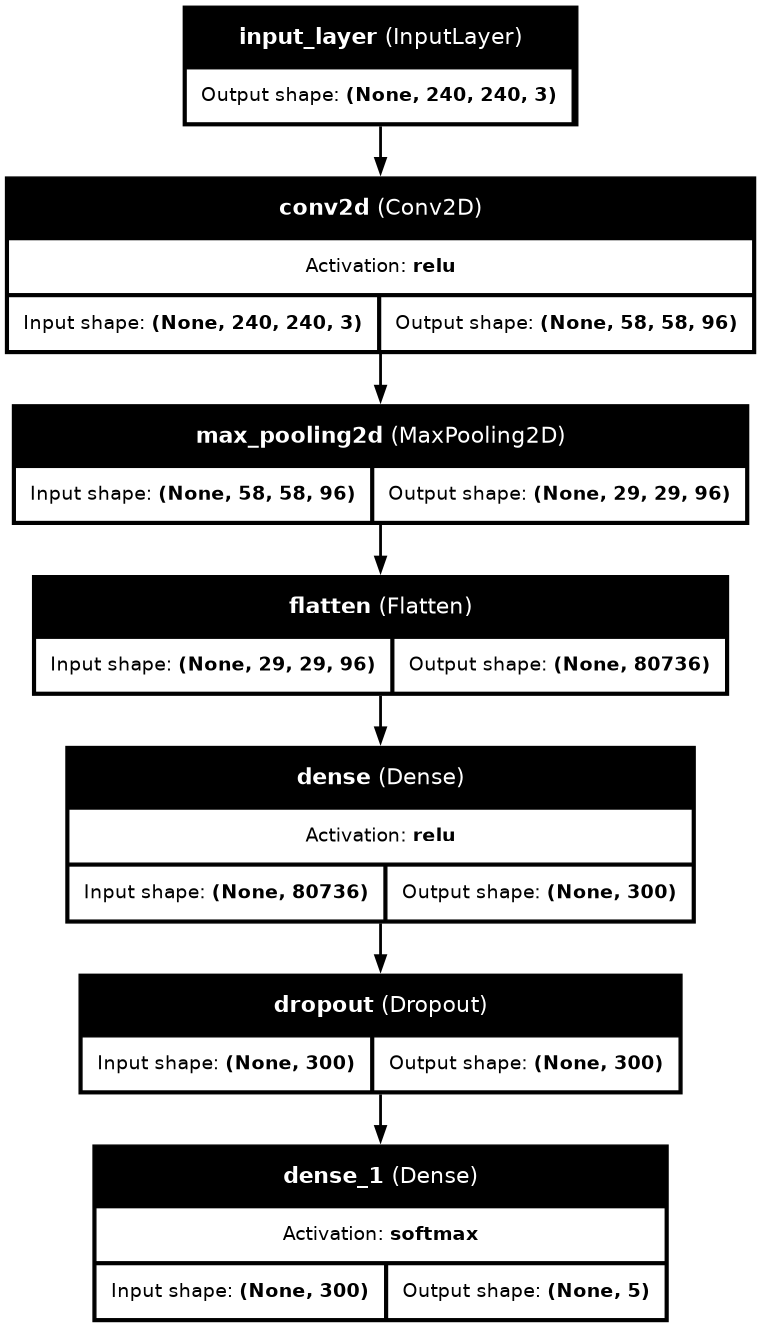

In [26]:
tf.keras.utils.plot_model(
    simpleCNN,
    to_file='alex_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [27]:
simpleCNN.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
SimpleCNN_model = simpleCNN.fit(train_data, epochs=10, validation_data=val_data)


Epoch 1/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1317s 747ms/step - accuracy: 0.9184 - loss: 0.0960 - val_accuracy: 0.9688 - val_loss: 0.0369
Epoch 2/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1227s 697ms/step - accuracy: 0.9694 - loss: 0.0378 - val_accuracy: 0.9710 - val_loss: 0.0341
Epoch 3/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1224s 696ms/step - accuracy: 0.9722 - loss: 0.0345 - val_accuracy: 0.9736 - val_loss: 0.0316
Epoch 4/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1285s 697ms/step - accuracy: 0.9773 - loss: 0.0271 - val_accuracy: 0.9756 - val_loss: 0.0299
Epoch 5/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1281s 697ms/step - accuracy: 0.9815 - loss: 0.0227 - val_accuracy: 0.9762 - val_loss: 0.0324
Epoch 6/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1239s 704ms/step - accuracy: 0.9854 - loss: 0.0176 - val_accuracy: 0.9748 - val_loss: 0.0317
Epoch 7/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1272s 698ms/step - accuracy: 0.9885 - loss: 0.0138 - val_accuracy: 0.9772 - val_loss: 0.0311
Epoch 8/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1294s 705ms/s

In [28]:
training_loss_simpleCNN = SimpleCNN_model.history['loss']
val_loss_simpleCNN = SimpleCNN_model.history['val_loss']
training_acc_simpleCNN = SimpleCNN_model.history['accuracy']
val_acc_simpleCNN = SimpleCNN_model.history['val_accuracy']

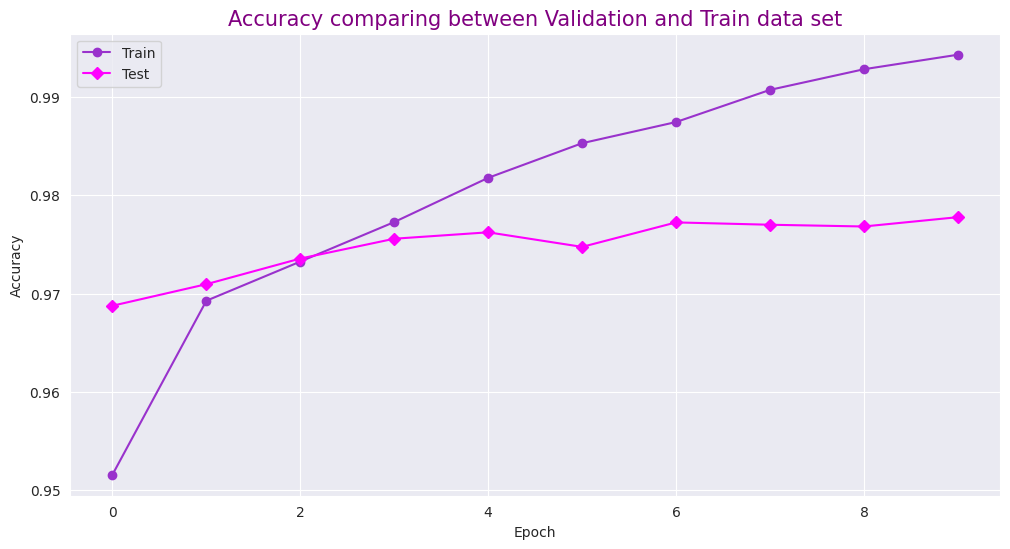

In [29]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
plt.plot(SimpleCNN_model.history['accuracy'], color='darkorchid', marker="o")
plt.plot(SimpleCNN_model.history['val_accuracy'],color='fuchsia', marker="D")
plt.title('Accuracy comparing between Validation and Train data set', fontsize=15, color='purple')
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

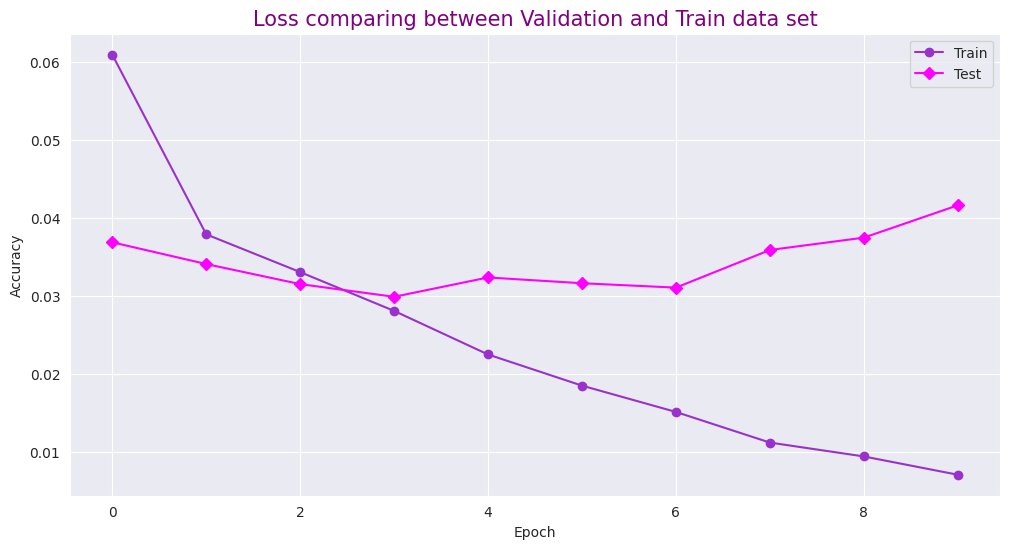

In [30]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
plt.plot(SimpleCNN_model.history['loss'], color='darkorchid', marker="o")
plt.plot(SimpleCNN_model.history['val_loss'],color='fuchsia', marker="D")
plt.title('Loss comparing between Validation and Train data set', fontsize=15, color='purple')
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [31]:

test_results = simpleCNN.evaluate(test_data, verbose = 2)

print(f'Test Loss: {test_results[0]:.5f}')
print(f'Test Accuracy: {(test_results[1] * 100):.2f}%')
'''
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print('\nTest accuracy:', test_acc)
'''

59/59 - 17s - 296ms/step - accuracy: 0.9765 - loss: 0.0437
Test Loss: 0.04370
Test Accuracy: 97.65%


"\ntest_loss, test_acc = model.evaluate(test_data, verbose=2)\nprint('\nTest accuracy:', test_acc)\n"

In [32]:
class_labels = list(train_data.class_indices.keys())

test_classes = test_data.classes
predicted_classes = np.argmax(simpleCNN.predict(test_data, verbose = 0), axis = 1)

print(f'Classification Report (Test) --> \n\n' + \
f'{classification_report(test_classes, predicted_classes, target_names = class_labels)}')

Classification Report (Test) --> 

              precision    recall  f1-score   support

     Arborio       0.98      0.97      0.98       383
     Basmati       0.96      0.97      0.97       368
      Ipsala       1.00      1.00      1.00       373
     Jasmine       0.97      0.96      0.97       389
   Karacadag       0.97      0.98      0.98       362

    accuracy                           0.98      1875
   macro avg       0.98      0.98      0.98      1875
weighted avg       0.98      0.98      0.98      1875

